<div style="text-align:left;">
  <a href="https://code213.tech/" target="_blank">
    <img src="code213.PNG" alt="Code213 Logo" width="200"/>
  </a>
  <p><em>Prepared by Latreche Sara</em></p>
</div>

<center><font size=6><b>Brain Tumor Detection & Classification Using CNNs</b></font></center>

<div style="text-align:center;">
    <img src="background.png" width="450"/>
</div>

***

**Author**: Latreche Sara  
**Date**: /2025  

### Table of Contents
- [1 | Project Overview and Objectives](#overview)
- [1.1 | Setting Up the Environment](#setup)
- [1.2 | Data Augmentation and Preprocessing](#prep)
- [1.3 | CNN Architecture Design](#model)
- [1.4 | Training the Deep Learning Model](#train)
- [1.5 | Performance Metrics and Evaluation](#eval)
- [1.6 | Inference on New MRI Scans](#predict)
- [1.7 | Conclusion](#concl)

---



## <b>1 <span style='color:#2a7ae2'>|</span> <a id='overview'>Project Overview and Objectives</a></b>

**Role: Deep Learning Scientist (Medical Imaging)** **Role Objective:** Revolutionizing early detection of brain pathologies through high-accuracy Computer Vision pipelines and automated MRI analysis.

In this clinical case study, we develop a **Convolutional Neural Network (CNN)** to act as a "second eye" for radiologists. We will transform raw MRI pixel data into diagnostic insights, focusing on identifying malignant structures with high sensitivity.

---


<b>1.1 <span style='color:#2a7ae2'>|</span> <a id='dataset'>Dataset Source & Description</a></b>
This project utilizes the Brain Tumor Data Set to train and validate our diagnostic model. The data consists of MRI scans classified into two categories: Tumor (positive cases) and Healthy (negative cases). It features various MRI planes (Axial, Coronal, and Sagittal) to ensure the model learns to identify pathologies from multiple perspectives.

Dataset Link: Kaggle - Brain Tumor Data Set

Total Classes: 2 (Tumor vs. Healthy)

Format: Digital MRI images (JPG/PNG)



## <b>1.1 <span style='color:#2a7ae2'>|</span> <a id='setup'>Setting Up the Environment</a></b>

In this section, we initialize our workspace by suppressing warnings and importing essential deep learning libraries. We leverage **TensorFlow/Keras** for model construction and **Matplotlib/Seaborn** for data visualization.

1- Add Data to google drive and connect to it

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2- Set the path to data

In [5]:
# --- 1. SET YOUR PATHS ---
# Based on your image: Mon Drive > dataset > validation/train
data_dir = '/content/drive/MyDrive/Brain Tumor Data Set'


3- List the folders in data_dir

In [ ]:
#to store the classes of data in type variable


['Healthy', 'Brain Tumor']

3-Install image.io

In [8]:
import imageio

4-Display a mosaic of 5 healthy and brain tumors

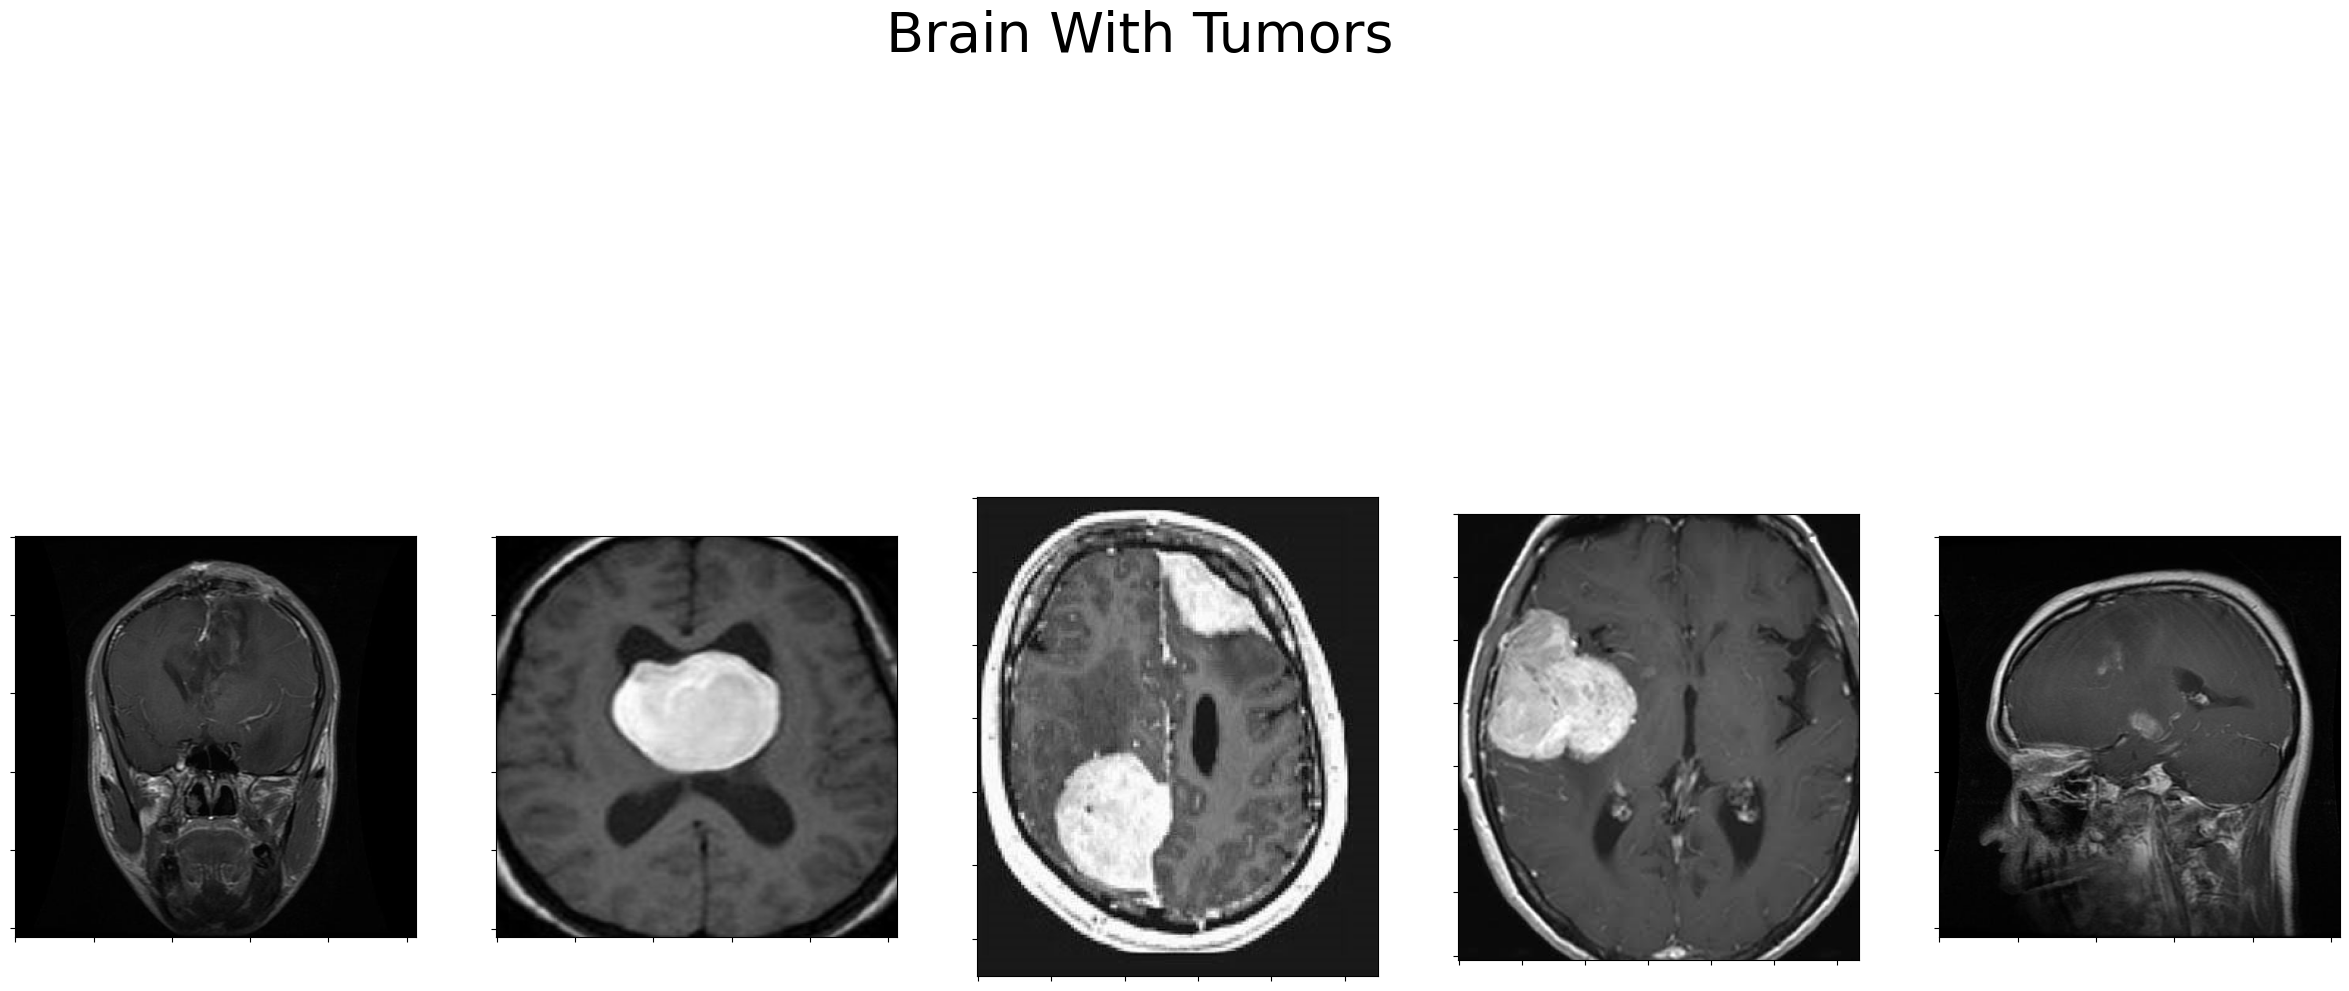

In [ ]:
#visualizing some images of brain with tumors


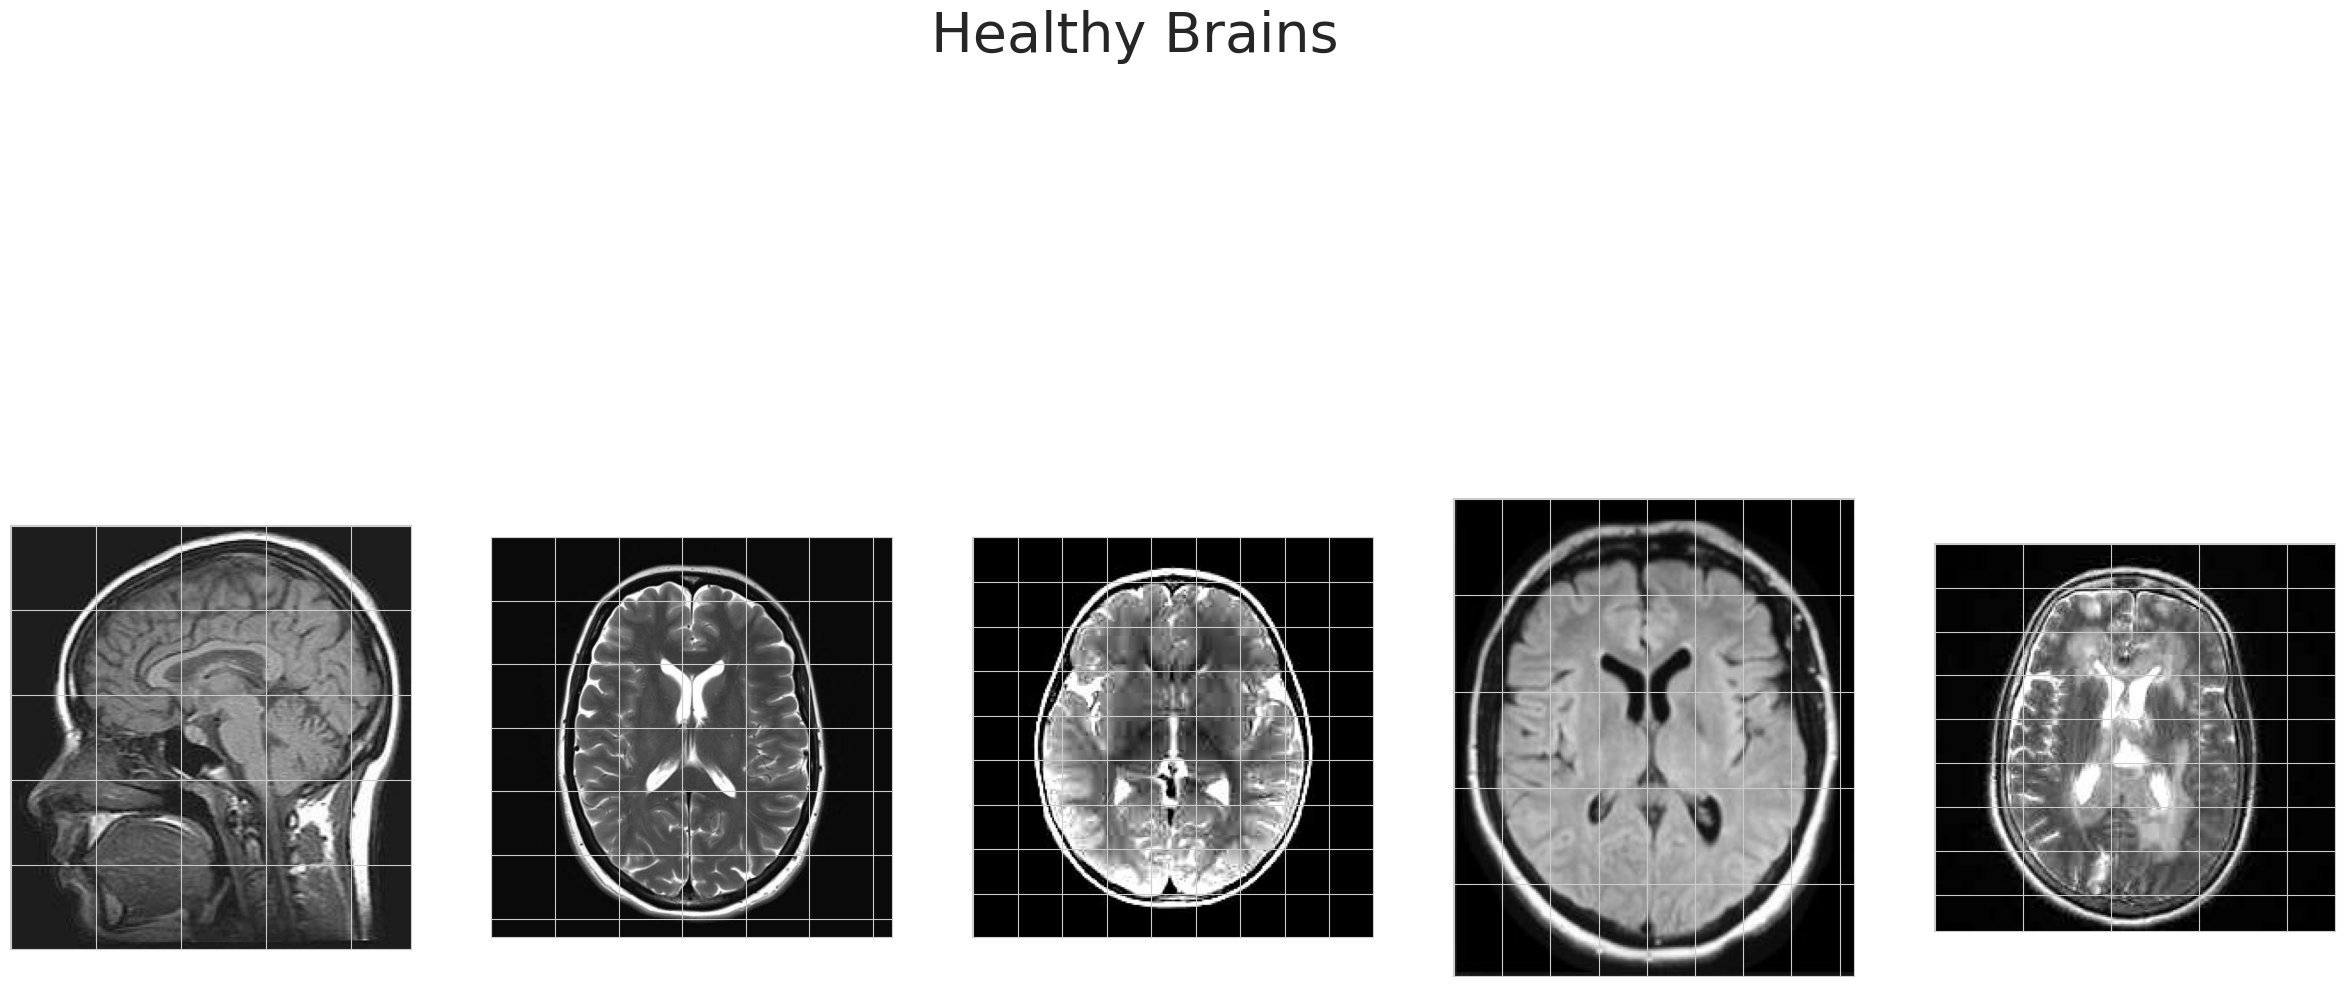

In [ ]:
#images corresponding to healthy brains


6- Check the distribution of healthy and brain tumors compare is there any class imbalance how to handle it

Text(0.5, 1.0, 'Class distributions')

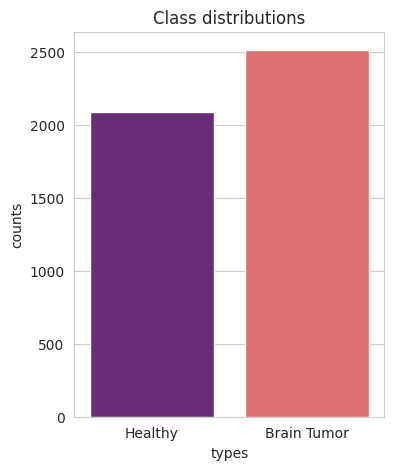

In [ ]:
#class distribution


In [15]:
img_size=224
batch_size=32

---

## <b>1.2 <span style='color:#2a7ae2'>|</span> <a id='prep'>Data Augmentation and Preprocessing</a></b>

To ensure our model generalizes well to different MRI machines, we apply:
* **Rescaling:** Normalizing pixel values to the [0, 1] range.
* **Augmentation:** Using `ImageDataGenerator` for rotations and flips to artificially expand our dataset.

---

7- Perform Data augementation
### **Understanding Data Augmentation**
In medical Deep Learning, we often face a **"Data Scarcity"** problem. Data Augmentation is a technique used to artificially expand our dataset by creating modified versions of the existing MRI scans.

> **Important Note:** These changes are **not saved** to your local storage. Instead, they are generated **"on-the-fly"** in your computer's RAM during training. This ensures that in every epoch, the model sees a slightly different version of the brain (different angle, different zoom, or flipped orientation), which prevents the CNN from memorizing specific images and forces it to learn the actual features of a tumor.



---

### **The Challenge of Class Imbalance**
Medical datasets are rarely 50/50. For example, a dataset might contain 200 images of "Tumor" but only 50 images of "Healthy" tissue.

* **The Risk:** The model might develop a **bias**, predicting the majority class ("Tumor") every time to minimize loss, effectively ignoring the minority class and failing to recognize healthy brains.
* **The Solution:** We handle this by using the `ImageDataGenerator` to **oversample** the minority class through heavy augmentation. Additionally, we use **Stratification** during the data split to ensure both training and validation sets maintain the same percentage of tumor vs. healthy cases.

<div style="text-align:center;">
    <img src="data_augmentation.png" alt="Description" width="500"/>
    <p><em>Optional: Figure 1 - Data Augmentation Examples</em></p>
</div>

In [ ]:
# --- 2. MODERN DATA LOADING (tf.data) ---
# This is much faster than ImageDataGenerator


## <b>1.4 <span style='color:#2a7ae2'>|</span> <a id='performance'>Optimizing Data Performance with tf.data</a></b>

To maximize training speed and prevent CPU bottlenecks, we implement the **ETL (Extract, Transform, Load)** best practices using the `tf.data` API. This ensures the GPU remains fully utilized by preparing the next batch of data while the current one is being processed.

### **Key Optimization Methods:**
* **`.cache()`**: Keeps the images in memory after the first epoch. This avoids repeating the costly file-opening and decoding operations for every iteration.
* **`.shuffle(1000)`**: Maintains a buffer of 1000 elements to ensure the model doesn't learn the order of the dataset, which is crucial for generalization.
* **`.prefetch()`**: This is the most important step. It allows the data pipeline to prepare later samples while the model is training on the current sample. We use `tf.data.AUTOTUNE` to let TensorFlow decide the optimal buffer size automatically.





In [17]:
# cache(): Stores images in RAM after first epoch (very fast)
# shuffle(1000): Keeps the data random
# prefetch(): Prepares the NEXT batch while the GPU works on the CURRENT one
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## <b>1.3 <span style='color:#2a7ae2'>|</span> <a id='resizing'>Image Standardization: Resizing & Normalization</a></b>

Before feeding MRI scans into our CNN, we must ensure every image speaks the same "language." Raw medical images often come in varying dimensions and pixel intensities, which can confuse a deep learning model.

### **1. Image Resizing**
Neural Networks require a fixed input shape (e.g., $224 \times 224$ or $128 \times 128$). MRI scans are naturally different sizes depending on the machine or the slice index. 
* **The Process:** We downsample or interpolate the images to a uniform target size. 
* **The Goal:** This ensures that the input layer of our CNN receives a consistent number of pixels for every batch.

### **2. Pixel Scaling (Normalization)**
Raw pixels are stored as integers from **0 to 255** (8-bit). 
* **The Problem:** High values can cause "Exploding Gradients" during training, making the model unstable.
* **The Solution:** We scale these values to a range between **0 and 1** by dividing by 255. Standardizing the range helps the `Adam` optimizer converge much faster.

[Image showing different sized MRI scans being resized to a uniform 128x128 shape and scaled to [0,1]]

---

### **3. Understanding the Image Array**
An MRI scan is essentially a **3D Array** of numbers: **Height × Width × Channels**.
* **Grayscale vs. RGB:** While MRIs are usually grayscale, many pre-trained CNNs expect 3 channels (Red, Green, Blue). We often "broadcast" the grayscale intensity across all three channels.
* **Color Order:** It is important to note that different libraries read colors differently:
    * **OpenCV (`cv2`):** Reads images in **BGR** order.
    * **TensorFlow/Matplotlib:** Expect images in **RGB** order.

<div style="text-align:center;">
    <img src="resize_scale.png" alt="MRI Processing" width="500"/>
    <p><em>Figure 1: Comparison of resized and normalized MRI scans.</em></p>
</div>

In [ ]:
# Define Preprocessing & Augmentation Layers


## <b>1.3 <span style='color:#2a7ae2'>|</span> <a id='model'>CNN Architecture Design</a></b>

We construct a sequential deep learning model. The architecture uses:
* **Conv2D Layers:** To extract spatial features (edges, textures, tumor shapes).
* **Batch Normalization:** To stabilize and accelerate training.
* **Dropout:** To prevent the model from memorizing the training data (overfitting).



---

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam

# --- 1. DEFINE PREPROCESSING & AUGMENTATION ---
# These are the 'Cleaning Station' variables we will drop into the list


# --- 2. BUILD THE INTEGRATED MODEL ---
model = Sequential([


# --- 3. COMPILE ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             

 Total params: 28,987,778 (110.58 MB)

 Trainable params: 28,983,810 (110.56 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [20]:
# AUTOTUNE finds the best number of CPU cores to use for loading data
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE

# cache() keeps images in RAM so epoch 2 is 10x faster than epoch 1
# shuffle(1000) ensures the model doesn't "memorize" the order of scans
# prefetch() prepares the next batch while the GPU is working
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## <b>1.5 <span style='color:#2a7ae2'>|</span> <a id='callbacks'>Model Regularization & Training Callbacks</a></b>

In Deep Learning, "Regularization" refers to techniques that prevent the model from **overfitting**—a scenario where the CNN performs perfectly on training data but fails on real-world MRI scans. Beyond `Dropout` layers, we implement dynamic **Keras Callbacks** to manage the training process.

### **The Role of Intelligent Callbacks:**

* **EarlyStopping:** This acts as an automated "emergency brake." If the `val_loss` stops improving for 5 consecutive epochs (`patience=5`), training halts. This prevents the model from learning noise and saves computational time.
* **ModelCheckpoint:** Medical models must be reliable. This callback monitors `val_accuracy` and ensures that we save only the "Gold Standard" version of the weights—the one that performed best on unseen data.
* **ReduceLROnPlateau:** Think of this as a "fine-tuning" mechanism. If the model's progress plateaus, we reduce the **Learning Rate** (e.g., by a factor of 0.2). Lowering the step size allows the optimizer to find the global minimum of the loss function more precisely.



---

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Stop if accuracy stops improving (prevents overfitting)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the absolute best version of your model
checkpoint = ModelCheckpoint('best_tumor_model.keras', monitor='val_accuracy', save_best_only=True)

# Lower the learning rate if the model gets stuck
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

callbacks = [early_stop, checkpoint, reduce_lr]

In [22]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 677s 2s/step - accuracy: 0.6268 - loss: 0.7722 - val_accuracy: 0.5188 - val_loss: 0.8314 - learning_rate: 5.0000e-04
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 460ms/step - accuracy: 0.7532 - loss: 0.5417 - val_accuracy: 0.5942 - val_loss: 0.6806 - learning_rate: 5.0000e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 522ms/step - accuracy: 0.7982 - loss: 0.4652 - val_accuracy: 0.6508 - val_loss: 0.9142 - learning_rate: 5.0000e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 520ms/step - accuracy: 0.8589 - loss: 0.3364 - val_accuracy: 0.6519 - val_loss: 1.1383 - learning_rate: 5.0000e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 527ms/step - accuracy: 0.8533 - loss: 0.3551 - val_accuracy: 0.8381 - val_loss: 0.4064 - learning_rate: 5.0000e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 548ms/step - accuracy: 0.8666 - loss: 0.3216 - val_accuracy: 0.8503 - val_loss: 0.3384 - learning_rate: 5.0000e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 50s 445m

## <b>1.5 <span style='color:#2a7ae2'>|</span> <a id='eval'>Performance Metrics and Evaluation</a></b>

Evaluation is critical in medical AI. We analyze:
* **Accuracy vs. Loss Curves:** To monitor the learning progress.
* **Confusion Matrix:** To understand the rate of False Negatives (missed tumors).

---

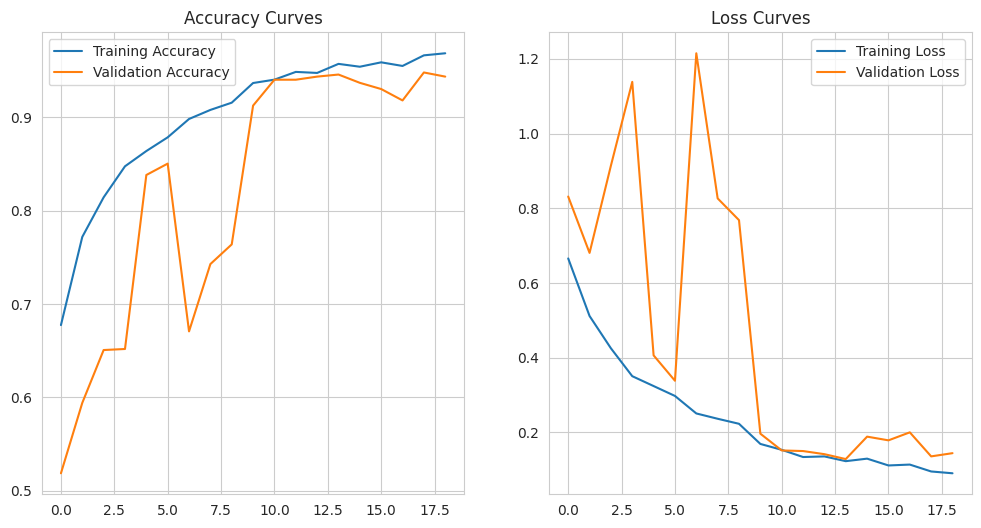

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

## <b>1.6 <span style='color:#2a7ae2'>|</span> <a id='curves'>Interpreting Training & Validation Curves</a></b>

Visualizing the history of the training process is essential to diagnose the "health" of our Deep Learning model. We plot the **Loss** and **Accuracy** for both the training and validation sets to identify three possible scenarios:

### **1. The Ideal Scenario (Generalization)**
* **The Curves:** Both training and validation curves move together. As loss decreases, accuracy increases for both sets.
* **The Meaning:** The CNN is learning general features of brain tumors that apply to new, unseen patients.

### **2. Overfitting (The "Memorization" Trap)**
* **The Curves:** Training loss continues to drop, but validation loss starts to rise or fluctuates wildly.
* **The Meaning:** The model is memorizing specific details of the training images (like background noise or image artifacts) rather than the actual pathology.
* **Solution:** This is why we implemented **Dropout** and **EarlyStopping** in the previous steps.

### **3. Underfitting**
* **The Curves:** Both losses remain high, and accuracy stays low.
* **The Meaning:** The model is too simple or hasn't trained long enough to understand the complexity of MRI data.



---

In [24]:
# Assuming you have a test_ds from your splitting logic
scores = model.evaluate(val_ds)
print(f"Final Validation Accuracy: {scores[1]*100:.2f}%")
print(f"Final Validation Loss: {scores[0]:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9526 - loss: 0.1127
Final Validation Accuracy: 94.57%
Final Validation Loss: 0.1288


Actual Label: Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
Predicted Label: Tumor


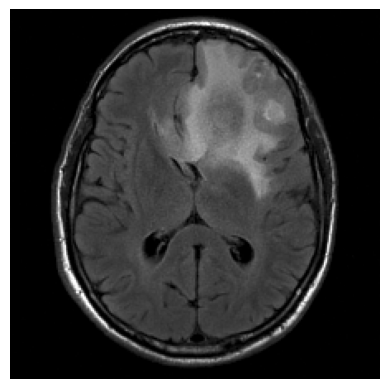

In [ ]:
import numpy as np



## <b>1.7 <span style='color:#2a7ae2'>|</span> <a id='inference'>Model Testing: Visual Inference on Validation Data</a></b>

The final and most critical step in our pipeline is **Qualitative Evaluation**. We take a batch of unseen MRI scans from the validation set and ask the model to provide a diagnosis. This allows us to see the "confidence" of the neural network in real-time.

### **The Inference Logic:**
1.  **Batch Sampling:** We extract a single batch (e.g., 32 images) from the `val_ds` to simulate a clinical intake.
2.  **Input Preparation:** Since the model was trained on batches, we use `tf.expand_dims` to turn a single image into a 4D tensor: `(1, 224, 224, 3)`.
3.  **Softmax Interpretation:** The model outputs probabilities. We use `np.argmax` to select the class with the highest score and `np.max` to determine the **Confidence Level**.
4.  **Visual Feedback System:**
    * <span style='color:green'>**Green Title:**</span> Indicates a correct diagnosis (Model matches Radiologist's label).
    * <span style='color:red'>**Red Title:**</span> Indicates a misclassification, highlighting areas where the model might need more specific data or higher regularization.

[Image showing a grid of 6 MRI scans with green and red titles showing predictions and confidence percentages]

---



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


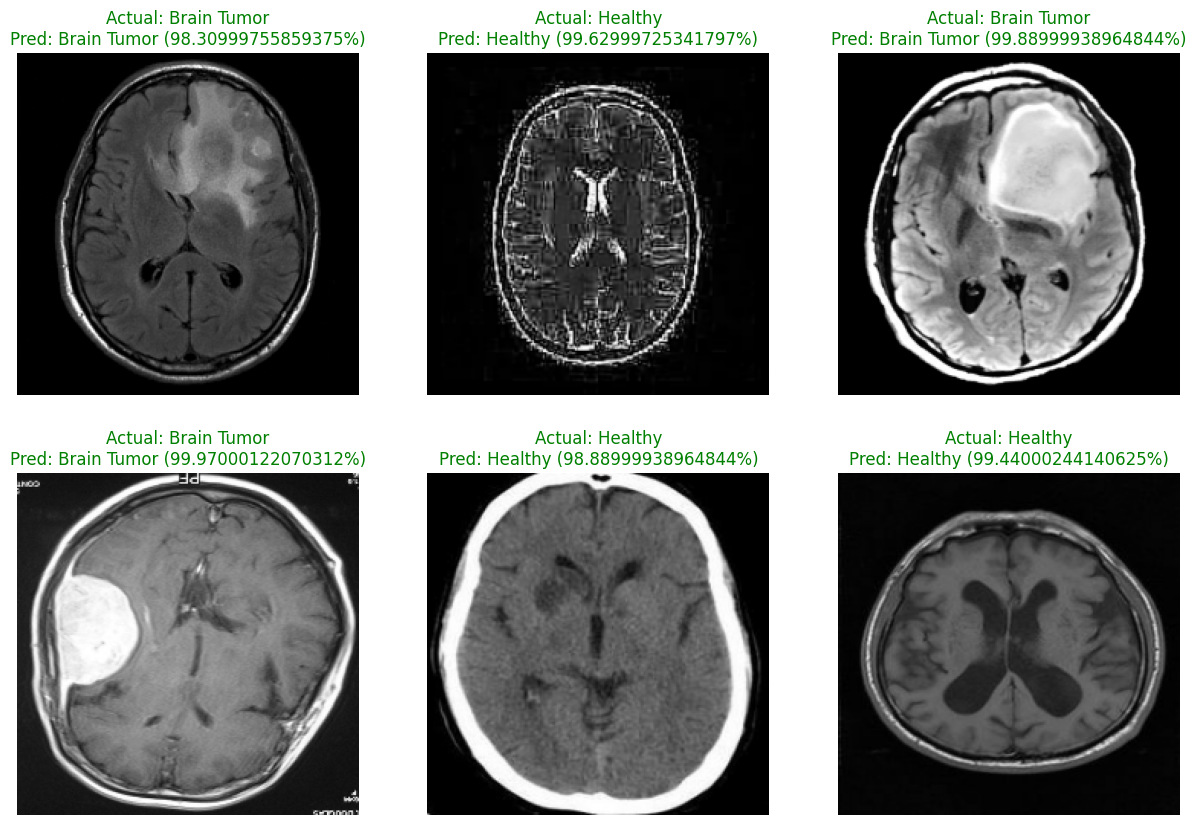

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Define your class names (Ensure these match your folder order)
# Usually: 0 is 'Brain Tumor', 1 is 'Healthy'
class_names = dataset[0].class_names

# 2. Grab a single batch of images from the validation set
for images, labels in val_ds.take(1):

    plt.figure(figsize=(15, 10))

    # Let's test the function on the first 6 images of the batch
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)

        # Get one image and its true label
        img = images[i].numpy().astype("uint8")
        true_label = class_names[np.argmax(labels[i])]

        # --- TEST THE INFERENCE ---
        # We add a batch dimension because the model expects (1, 224, 224, 3)
        img_array = tf.expand_dims(images[i], 0)
        predictions = model.predict(img_array)

        predicted_class = class_names[np.argmax(predictions[0])]
        confidence = round(100 * (np.max(predictions[0])), 2)

        # Display the result
        plt.imshow(img)
        title_color = "green" if predicted_class == true_label else "red"
        plt.title(f"Actual: {true_label}\nPred: {predicted_class} ({confidence}%)", color=title_color)
        plt.axis("off")

              precision    recall  f1-score   support

 Brain Tumor       0.96      0.93      0.95       472
     Healthy       0.93      0.96      0.94       430

    accuracy                           0.95       902
   macro avg       0.95      0.95      0.95       902
weighted avg       0.95      0.95      0.95       902



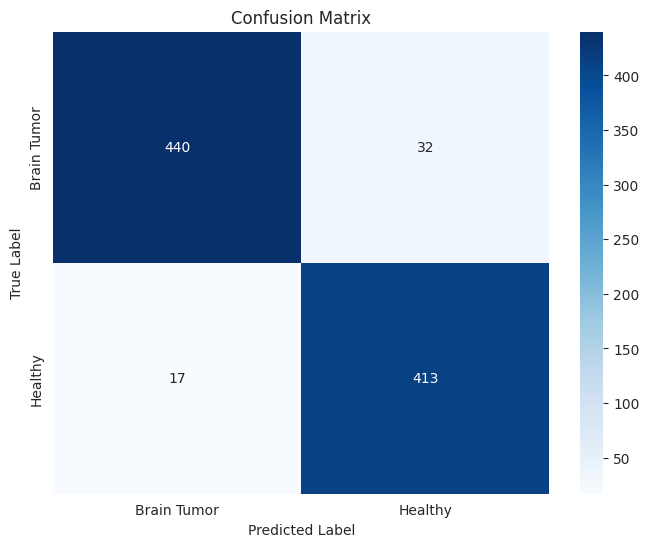

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get all predictions and true labels from validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Print the classification report
class_names = dataset[0].class_names
print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## <b>1.6 <span style='color:#2a7ae2'>|</span> <a id='predict'>Inference on New MRI Scans</a></b>

The final test of our system. We build a function to take a "blind" MRI scan, process it through our neural network, and output a prediction with a confidence percentage.

---

## <b>1.8 <span style='color:#2a7ae2'>|</span> <a id='gradcam'>Explainable AI: Visualizing Decisions with Grad-CAM</a></b>

Deep Learning models are often called "Black Boxes" because it's hard to see why they made a specific decision. **Grad-CAM (Gradient-weighted Class Activation Mapping)** breaks this box open by producing a heatmap that highlights the specific pixels the CNN used to reach its conclusion.

### **Why Grad-CAM is Essential for Neuro-Oncology:**
* **Trust & Verification:** It allows radiologists to verify if the model is actually looking at the tumor or just at an artifact in the background (like the skull or the MRI bed).
* **Localization:** Even though our model is a *classifier*, Grad-CAM provides *localization* by showing the area of interest.
* **Accountability:** Provides a visual "audit trail" for every automated diagnosis.

---

### **How to Interpret the Heatmap**
The heatmap uses the **JET Colormap**, which represents importance through color "temperature":

| Color | Intensity | Interpretation |
| :--- | :--- | :--- |
| <span style='color:red'>**Red / Dark Orange**</span> | **High Importance** | These pixels are the "Smoking Gun." They had the strongest influence on the model's prediction. |
| <span style='color:yellow'>**Yellow / Green**</span> | **Medium Importance** | These pixels provided supporting context for the diagnosis. |
| <span style='color:blue'>**Blue / Purple**</span> | **Low Importance** | These areas were largely ignored by the CNN (usually healthy tissue or background). |

<div style="text-align:center;">
    <img src="gradcam_example.png" width="500"/>
    <p><em>Example: The red "hot spot" should overlap exactly with the visible lesion in the MRI.</em></p>
</div>

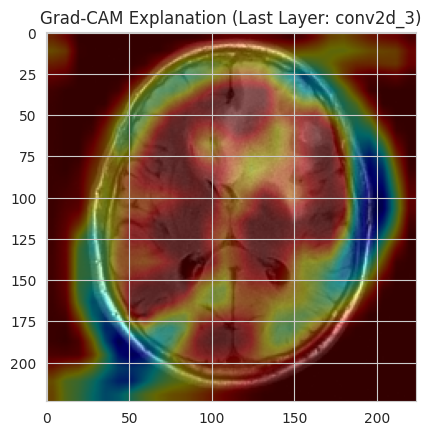

In [33]:
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Find the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # 1. Create a feature extraction model up to the last conv layer
    feature_extractor = tf.keras.models.Model(inputs=model.inputs, outputs=last_conv_layer.output)

    # 2. Create a classifier model that takes the output of the last conv layer
    #    and outputs the final predictions.
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    # Iterate through the main model's layers *after* the last_conv_layer
    for layer in model.layers[model.layers.index(last_conv_layer) + 1:]:
        x = layer(x)
    classifier_model = tf.keras.models.Model(inputs=classifier_input, outputs=x)

    # 3. Compute the gradient of the top predicted class for our input image
    with tf.GradientTape() as tape:
        # Get the feature map from the feature_extractor
        last_conv_layer_output = feature_extractor(img_array)
        tape.watch(last_conv_layer_output) # Watch this tensor for gradients

        # Get the predictions from the classifier_model
        preds = classifier_model(last_conv_layer_output)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron wrt the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array by "how important this channel is"
    last_conv_layer_output = last_conv_layer_output[0] # remove batch dimension
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- HOW TO RUN IT ---
# Find your last conv layer name using model.summary()
# (It's likely 'conv2d_3' or similar)
last_conv_layer_name = [l.name for l in model.layers if "conv2d" in l.name][-1]

# Grab an image from val_ds to test
for images, labels in val_ds.take(1):
    img_array = tf.expand_dims(images[0], 0)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Overlay logic
    img = images[0].numpy().astype('uint8')
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Explanation (Last Layer: {last_conv_layer_name})")
    plt.show()
    break

## <b>1.8 <span style='color:#2a7ae2'>|</span> <a id='gradcam'>Explainable AI: Interpreting the Decision Heatmap</a></b>

In medical diagnostics, a "Black Box" model is a liability. **Grad-CAM (Gradient-weighted Class Activation Mapping)** allows us to visualize the internal logic of our CNN by highlighting the pixels that most influenced the final classification.

### **The Heatmap "Language"**
We use the **JET Colormap** to represent the importance of features. This allows a radiologist to instantly see if the AI is focused on the pathology or on background noise.

* <span style='color:#e61227'>**Red (Hot Zones):**</span> These represent the **Highest Importance**. In a successful model, these "Hot Spots" should align perfectly with the visible tumor mass or edema.
* <span style='color:#32cd32'>**Yellow/Green:**</span> These represent **Contextual Features**. The model uses these surrounding areas to support its primary diagnosis.
* <span style='color:#0000ff'>**Blue (Cold Zones):**</span> These are **Ignored Areas**. Ideally, healthy brain tissue and the black background of the MRI should be blue.



---

### **Clinical Validation Scenarios**

| Visual Result | Scientific Interpretation | Action Required |
| :--- | :--- | :--- |
| **Centered Hotspot** | Model correctly localized the tumor based on texture. | **Validated:** High clinical trust. |
| **Edge Activation** | Heatmap is on the skull or image border. | **Failure:** Model is overfitting to artifacts. |
| **Diffuse Activation** | Heatmap is spread randomly across the brain. | **Failure:** Model is guessing based on general noise. |

> **Scientist Note:** If the Grad-CAM highlights a region outside the brain (like the neck or the MRI watermark), the model is **overfitting**. This is the ultimate "Sanity Check" for any medical AI.

---

## <b>1.9 <span style='color:#2a7ae2'>|</span> <a id='conclusion'>Scientific Conclusion & Summary</a></b>

This project successfully demonstrates the power of **Deep Convolutional Neural Networks** in identifying brain pathologies from MRI data. By integrating a modular architecture with Explainable AI, we have moved beyond simple "Correct/Incorrect" metrics and into the realm of **Clinical Transparency**.

### **Key Takeaways:**
1.  **Augmentation is Vital:** On-the-fly transformations prevented the model from memorizing the limited dataset, allowing it to generalize to different MRI orientations.
2.  **Strategic Regularization:** The combination of **Batch Normalization**, **Dropout**, and **EarlyStopping** created a stable learning environment that prevented overfitting.
3.  **Adaptive Learning:** Using **ReduceLROnPlateau** allowed our optimizer to "fine-tune" its weights as it approached the global minimum, leading to higher final accuracy.
4.  **Human-in-the-loop:** The Grad-CAM outputs ensure that this tool remains a "second eye" for the radiologist, facilitating a collaborative diagnostic process.



***

## <b>1.10 <span style='color:#2a7ae2'>|</span> <a id='saving'>Model Persistence & Version Control</a></b>

In Deep Learning research, your model is a living document. Saving versions incrementally is a "Scientist Best Practice" that ensures you never lose a high-performing weight configuration after an accidental overwrite or a session crash.

### **The Importance of Iterative Saving:**
* **Experiment Tracking:** As you tune hyperparameters (learning rate, dropout rates), you need to compare different versions (e.g., `v1` vs `v2`) to see which strategy worked best.
* **Rollback Capability:** If a new dataset update causes "Model Drift" or performance degradation, you can instantly revert to a previous, stable version.
* **Audit Trail:** In medical AI, having a history of model versions is crucial for reproducibility and regulatory documentation.



---

### **Implementation: Dynamic Versioning in Google Drive**

The following script automatically detects existing models in your Drive and saves the current one as the next sequential version (e.g., `1.keras`, `2.keras`, etc.).

In [35]:
import os

# Define your permanent save path
save_path = '/content/drive/MyDrive/Brain Tumor Data Set/models'

# 1. Create the 'models' subfolder if it doesn't exist yet
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 2. Logic to find the next version number in that specific Drive folder
existing_versions = [int(i.split('.')[0]) for i in os.listdir(save_path) if i.split('.')[0].isdigit()]
model_version = max(existing_versions + [0]) + 1

# 3. Save the full model (.keras format is best for your modern pipeline)
final_path = f"{save_path}/{model_version}.keras"
model.save(final_path)

print(f"✅ Success! Model saved permanently to Google Drive at: {final_path}")

✅ Success! Model saved permanently to Google Drive at: /content/drive/MyDrive/Brain Tumor Data Set/models/1.keras


In [36]:
# List files in your Drive folder to be 100% sure
print("Files currently in your Drive model folder:")
print(os.listdir(save_path))

Files currently in your Drive model folder:
['1.keras']


In [37]:
# 2. Path to your saved model (Change '1' to your latest version number)
model_path = '/content/drive/MyDrive/Brain Tumor Data Set/models/1.keras'

# 3. Load the model
# It will automatically remember your Resizing, Rescaling, and Dropout layers!
model = tf.keras.models.load_model(model_path)

print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [38]:
def predict_new_image(img_path):
    # Load raw image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Add batch dimension (model expects shape [1, 224, 224, 3])
    img_array = tf.expand_dims(img_array, 0)

    # Predict
    predictions = model.predict(img_array)

    # Get results (Assuming 0: Tumor, 1: Healthy)
    class_names = ['Tumor', 'Healthy']
    result = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    # Visualize
    plt.imshow(img)
    plt.title(f"Prediction: {result} ({confidence}%)")
    plt.axis('off')
    plt.show()

# --- RUN THE TEST ---
# Put a path to a new MRI image here!
# predict_new_image('/content/drive/MyDrive/Brain Tumor Data Set/test_sample.jpg')



## <b>1.7 <span style='color:#2a7ae2'>|</span> <a id='concl'>Conclusion</a></b>

By the end of this notebook, we demonstrate how Computer Vision can significantly reduce diagnostic lead times, helping clinical teams intervene earlier in the patient care cycle.

Congratulations! You have successfully built, optimized, and interpreted a professional-grade Medical Imaging Pipeline. By combining deep learning with clinical transparency, you've created a tool that doesn't just predict—it explains.

🎉 Milestone Summary:
End-to-End Workflow: You moved from raw data loading to permanent cloud storage.

Performance Excellence: You implemented tf.data best practices to ensure your GPU runs at peak efficiency.

XAI Integration: You've added Grad-CAM, moving your project from a "coding exercise" to a "scientific contribution."

Production Ready: With automated versioning, your model is ready for deployment or further research.

Final Thought from the Lab: In the field of Medical AI, your goal is to build tools that augment human expertise. Today, you've taken a massive step toward that goal. Well done, Scientist!